
# Deep Learning Course

 <img src="http://usblogs.pwc.com/emerging-technology/wp-content/uploads/2017/07/deep-learning-900x280.png" >


# Deep Learning - Stacking Model

Developed by [Sergio Castelblanco](http://www.linkedin.com/in/sergio-castelblanco/) - [Jesús Solano](mailto:ja.solano588@uniandes.edu.co)


version 2.0, July  2018

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
import livelossplot
%matplotlib inline

Using TensorFlow backend.


In [0]:
# If datasets already exist do nothing. 


if not os.path.exists('dataTesting.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTesting.csv
    
if not os.path.exists('dataTraining.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTraining.csv
    

if not os.path.exists('images_resize_gray.zip'):
  # Install the PyDrive wrapper & import libraries.
  # This only needs to be done once per notebook.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download a file based on its file ID(Grey).
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  file_id = '1ZzSvFeCsLVW4hPWqyf6jW0rAvyQt1L7J'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(downloaded['title'])
  !unzip -q images_resize_gray.zip 

  # Download a file based on its file ID(Color).
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  # id 160x256 95 : 1ZO1wPtxWfnthbm2NrXt4ca1ZvuxQWD_r
  #file_id = '1hAOuBMKUJDiyaHz6fVkwwSAHkmEVNvmP'
  
  #file_id = '1ZO1wPtxWfnthbm2NrXt4ca1ZvuxQWD_r'
  #downloaded = drive.CreateFile({'id': file_id})
  #downloaded.GetContentFile(downloaded['title'])
  #!unzip -q images_resize_color.zip 

dataTraining = pd.read_csv("dataTraining.csv",index_col=0)
dataTesting = pd.read_csv("dataTesting.csv",index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Read Images

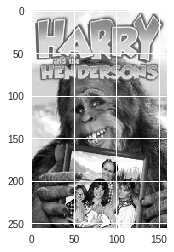

In [5]:
# Show an image example - Gray .
image = io.imread(os.path.join('images_resize_gray', str(dataTraining.index[124]) + '_resize_gray.jpeg'))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

In [6]:
# Load all gray images.

from skimage.transform import resize

print('\nLoading images for traning...')
images_training = []
for i in dataTraining.index:
    img=io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg'))
    img = resize(img, (80, 128), mode='reflect')
    img = [img] * 3
    images_training.append(img)
    
trainingImagesGray = np.asarray(images_training)


Loading images for traning...


In [7]:
'''

from skimage.transform import resize
print('\nLoading images for testing...')
images_testing = []
for i in dataTesting.index:
    img= io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg'))
    img = resize(img, (80, 128), mode='reflect')
    img = [img] * 3
    images_testing.append(img)

testingImagesGray = np.asarray(images_testing)

'''

"\n\nfrom skimage.transform import resize\nprint('\nLoading images for testing...')\nimages_testing = []\nfor i in dataTesting.index:\n    img= io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg'))\n    img = resize(img, (80, 128), mode='reflect')\n    img = [img] * 3\n    images_testing.append(img)\n\ntestingImagesGray = np.asarray(images_testing)\n\n"

In [0]:

trainingImagesGray = np.rollaxis(trainingImagesGray, 1, 4)



In [9]:
'''

testingImagesGray = np.rollaxis(testingImagesGray, 1, 4)

'''

'\n\ntestingImagesGray = np.rollaxis(testingImagesGray, 1, 4)\n\n'

In [0]:
# Get labels for each image. 

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
yGenres = le.fit_transform(dataTraining['genres'])

## Images Preprocessing - VGG

In [0]:
from keras.applications import VGG16
from skimage.transform import resize

vgg16 = VGG16(include_top=False, weights='imagenet')

trainingImagesVGG = vgg16.predict(trainingImagesGray)

# Creates datasets for training and testing.   
xTrainImaGrayVGG, xValidationImaGrayVGG, yTrainImaGrayVGG, yValidationImaGrayVGG = train_test_split(trainingImagesVGG, yGenres, test_size=0.20, random_state=22)

## Text Preproccesing - Word2Vec 

In [0]:
# Load functions and prerrequisites of word2vec.



import tensorflow_hub as hub
import tensorflow as tf
import numpy as np


hub_model = "https://tfhub.dev/google/Wiki-words-250/1"


def create_text_embedding(hub_model, input_sentences):
        
    SEQ_LENGTH = max(map(len, input_sentences))
    EMBEDDING_DIM = 250

    with tf.Graph().as_default() as g:

        embed_layer = hub.Module(hub_model,
        trainable=False, name='text_embedding')

        sentences = tf.placeholder(dtype=tf.string, shape=(None, SEQ_LENGTH))
        batch_size = tf.shape(sentences)[0]

        flat_sentences = tf.reshape(sentences, [-1])

        embeddings = embed_layer(flat_sentences)

        sentence_embedding = tf.reshape(embeddings, 
                                      [batch_size, SEQ_LENGTH, EMBEDDING_DIM])

        with tf.Session(graph=g) as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            output = sess.run(sentence_embedding, feed_dict={
                sentences: input_sentences
            })
            
    return output

In [0]:
# Get plots and lables for each plot.

xPlot=dataTraining['plot']
xPlotTest = dataTesting['plot']


In [15]:
# Converts a text to a sequence of words (or tokens)

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences


maxWords = 200

xTokenTrain = [text_to_word_sequence(x) for x in xPlot.tolist()]
xTokenTrain = pad_sequences(xTokenTrain, dtype='str', value=0, maxlen=maxWords)

xTokenTest = [text_to_word_sequence(x) for x in xPlotTest.tolist()]
xTokenTest = pad_sequences(xTokenTest, dtype='str', value=0, maxlen=maxWords)

xTokenTrain.shape

(7895, 200)

In [16]:
# Apply Word2Vec

xEmbeddingTrain = create_text_embedding(hub_model, xTokenTrain)

xEmbeddingTrain.shape

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


(7895, 200, 250)

In [22]:
'''
# Apply Word2Vec to test.

xEmbeddingTest = create_text_embedding(hub_model, xTokenTest)

xEmbeddingTest.shape

'''

INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


(3383, 200, 250)

In [17]:
# Creates datasets for training and testing.   
xTrainTxt, xValidationTxt, yTrainTxt, yValidationTxt = train_test_split(xEmbeddingTrain, yGenres, test_size=0.20, random_state=22)
xTrainTxt.shape

(6316, 200, 250)

## Stacking Model

In [18]:
from keras.models import load_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.models import model_from_config, Sequential


! wget "https://github.com/castellwhite/MoviesClassification/raw/master/nnTrained/imaNNtrainedGrayVGG.h5"

! wget "https://github.com/castellwhite/MoviesClassification/raw/master/nnTrained/txtWord2Vec2.h5"

--2018-07-23 17:08:30--  https://github.com/castellwhite/MoviesClassification/raw/master/nnTrained/imaNNtrainedGrayVGG.h5
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/nnTrained/imaNNtrainedGrayVGG.h5 [following]
--2018-07-23 17:08:31--  https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/nnTrained/imaNNtrainedGrayVGG.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25374264 (24M) [application/octet-stream]
Saving to: ‘imaNNtrainedGrayVGG.h5.3’

imaNNtrainedGrayVGG 100%[===================>]  24.20M  --.-KB/s    i

In [0]:
# Load pretrained models.

from keras.models import load_model

Model_Ima= load_model('imaNNtrainedGrayVGG.h5')
Model_Text= load_model('txtWord2Vec2.h5')

In [0]:
# Load predictions of trained models. 

predIma = Model_Ima.predict(xTrainImaGrayVGG)
predText =Model_Text.predict(xTrainTxt)

predImaValidation = Model_Ima.predict(xValidationImaGrayVGG)
predTxtValidation =Model_Text.predict(xValidationTxt)

In [0]:
import numpy as np

stackTrain =  np.c_[predIma,predText]
stackValidation = np.c_[predImaValidation,predTxtValidation]

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense ,BatchNormalization
from keras import backend as K
from keras import optimizers as opts
from keras.callbacks import History
from livelossplot import PlotLossesKeras

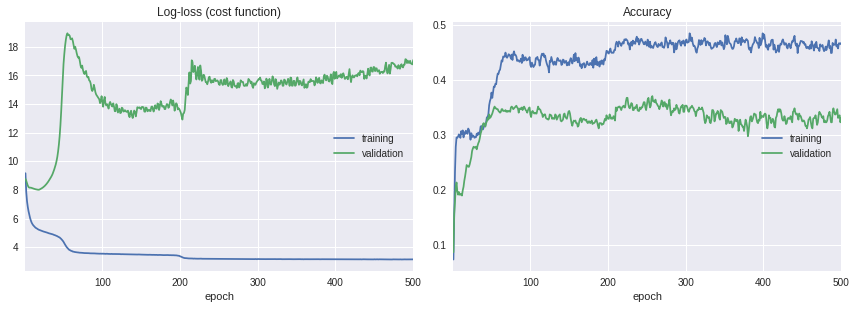

In [35]:
# We build a neural network whichs recieves as input a vector of probabilites of Image and Text models. Then the input is (numbersOfSamples, output probabilities TXT + output probabilities IMA )

from keras import backend as K
K.clear_session()

outputClasses= 24

mixModel = Sequential()
mixModel.add(Dense(512, input_shape=(stackTrain.shape[1],)))
mixModel.add(Activation('selu'))
mixModel.add(BatchNormalization())
mixModel.add(Dropout(0.5))
mixModel.add(Dense(outputClasses, activation='sigmoid'))
mixModel.summary()

mixModel.compile(loss='categorical_crossentropy',
              optimizer=opts.adam(lr=0.001), 
                 metrics=["accuracy"])

batch_size = 2000

mixModel.fit(stackTrain, yTrainTxt, 
             epochs = 500,
             verbose = 2,
             batch_size=batch_size, 
             validation_split=0.1,
             callbacks=[PlotLossesKeras()])

mixModel.save('mixNNtrained_Stack.h5')


In [36]:
# Scoring model for grey images.

from sklearn.metrics import roc_curve, auc, roc_auc_score

yPredGenreMix = mixModel.predict(stackValidation)
imaAUC = roc_auc_score(yValidationTxt, yPredGenreMix, average='macro')

# Perform the neural network over the test set. 

print('Evaluating the test set...')
score = mixModel.evaluate(stackValidation, yValidationImaGrayVGG)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])
print('Model AUC is: ', imaAUC )

Evaluating the test set...
1579/1579 [==============================] - 0s 81us/step

Test score: 17.177067993410482
Test accuracy: 0.29765674483179666
Model AUC is:  0.7437173226798645


In [0]:
from google.colab import files
files.download('mixNNtrained_Stack.h5')

In [28]:
!ls

datalab		    images_resize_gray.zip    imaNNtrainedGrayVGG.h5?raw=true
dataTesting.csv     imaNNtrainedGrayVGG.h5    txtWord2Vec.h5
dataTraining.csv    imaNNtrainedGrayVGG.h5.1  txtWord2Vec.h5.1
images_resize_gray  imaNNtrainedGrayVGG.h5.2


In [0]:
!pip3 install tqdm
!pip3 install livelossplot